# Part 1) Choice of Data Source

For this analysis, we utilize two datasets:
- **Fast Food Restaurants Across America** (Kaggle): A list of 10,000 fast food restaurants, including each restaurant's name, address, city, state, and geographic coordinates.
- **Dangerous Places in USA: 2013 - 2018** (Kaggle): A record of incidents of gun violence in the USA from 2013 to 2018, including location (latitude/longitude) and incident details (number of people injured/killed, etc).

**Data Format and Structure:** Both datasets are provided as CSV files. The fast food dataset is split across two CSV files which we will merge. The gun violence dataset is a single large CSV file.

**Potential Pitfalls and Quirks:**
- The fast food dataset is split into two files with overlapping entries. We need to merge them and remove duplicates.
- State names in the fast food data are given as two-letter abbreviations; we'll convert these to full state names for clarity.
- Date fields are in string format (ISO timestamp) and need parsing to datetime.
- Some entries have missing data, e.g., missing coordinates. We will drop those records since location is critical for our analysis.
- In the gun violence data, multiple gun types or statuses can be listed in one field as combined strings (separated by '||' or in '::' format). This requires parsing if we want to analyze gun types.
- The gun violence dataset is large, so performance and memory need to be considered when processing (e.g., writing out chunks to Excel, using efficient merges).

## Part 2) Choice of Frameworks

Investigate data processing and visualization frameworks and choose which ones to use in your project.
Create a brief comparison of the frameworks you have researched, their benefits and drawbacks and how they can interact / support each other.

Frameworks used:
`numpy`, `pandas`, `matplotlib`, `datetime`, `scipy`, `geopandas`, `shapely`, `openpyxl`, `contextily`, `kagglehub`, `threading`, `concurrent.futures`, `multiprocessing`

| Framework                                 | Purpose / Use Case                                                          | Benefits                                                                  | Drawbacks                                                             | Interactions/Support                       |
|-------------------------------------------|----------------------------------------------------------------------------|---------------------------------------------------------------------------|-----------------------------------------------------------------------|--------------------------------------------|
| **pandas**                                | Data handling, filtering, merging, cleaning, statistics, exporting to Excel | Rich in features, widely used, integrates well with plotting and file I/O | Can be memory-heavy for large datasets                                | Works with NumPy, Matplotlib, OpenPyXL     |
| **numpy**                                 | Efficient numerical computation and transformation (e.g. square roots)      | Very fast with large numeric arrays and broadcasting                      | More complex syntax for beginners                                     | Backbone for Pandas                        |
| **matplotlib**                            | Static plotting (bar plots, pie charts, etc.)                               | High customizability, widely supported                                    | Verbose syntax, complex layout tuning (e.g. `tight_layout` warnings)  | Works with Pandas, NumPy                   |
| **datetime**                              | Timestamp parsing and formatting                                            | Native to Python, integrates with pandas                                  | Not vectorized like Pandas datetime functions                         | Converts formats for Excel export          |
| **geopandas**                             | Geographic processing and spatial joins using shapefiles/coordinates        | Extends pandas for geospatial workflows                                   | Depends on installation of compiled packages (Shapely, Fiona, pyproj) | Integrates with Matplotlib and Shapely     |
| **shapely**                               | Geometry operations like distance calculation between lat/lon points        | Simple geometric API                                                      | Requires EPSG projection setup for accurate distance                  | Used in GeoPandas                          |
| **openpyxl**                              | Export to Excel formats including `.xlsx`                                   | Full control over Excel output                                            | Slower than CSV for large files                                       | Used by Pandas Excel backend               |
| **contextily**                            | Adds tiled web maps to geospatial plots                                     | Allows beautiful basemap integration (e.g. OpenStreetMap)                 | Requires good CRS and internet connection                              | Works with GeoPandas plots                 |
| **kagglehub**                             | Programmatic dataset download from Kaggle                                   | Automates reproducibility and avoids manual download                      | Requires Kaggle token/API setup                                       | Downloads into usable directory for Pandas |
| **threading / futures / multiprocessing** | Accelerated spatial queries across restaurants                              | Parallelism across CPU cores for faster execution                         | Requires careful locking / data structure coordination                | Handles each restaurant individually       |

## Part 3) Loading the Data

In this section, we acquire the data from the online sources and load it into our Python environment.

We use Kaggle's API via the `kagglehub` library to download the latest version of each dataset. After downloading, we identify the relevant CSV files for each dataset and prepare to load them using pandas.

**Loading Steps:**
1. **Download datasets** – Using `kagglehub.dataset_download()`, we retrieve the fast food restaurant dataset and the gun violence dataset.
2. **Locate files** – We use Python's `glob` to find the CSV files in the downloaded directories.
3. **Read data into pandas** – We will read the CSV files into pandas DataFrames for further processing (this is done in the cleaning step).

In [5]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import threading
import geopandas
import kagglehub
import numpy as np
import pandas as pd
import os
import glob
import os.path
import openpyxl
from datetime import datetime
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.colors as mathcolors
import contextily as ctx

from tqdm import tqdm
from threading import Lock
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing

print("-------------------Download Datasets-------------------")
# Download the latest version of the fast food restaurants dataset
path = kagglehub.dataset_download("imtkaggleteam/fast-food-restaurants-across-america")
print("Path to dataset files for fast food restaurants:", path)

# Download the latest version of the gun violence dataset
path2 = kagglehub.dataset_download("jameslko/gun-violence-data")  # "sobhanmoosavi/us-accidents"
print("Path to dataset files for gun violence:", path2)

-------------------Download Datasets-------------------
Path to dataset files for fast food restaurants: C:\Users\benja\.cache\kagglehub\datasets\imtkaggleteam\fast-food-restaurants-across-america\versions\1
Path to dataset files for gun violence: C:\Users\benja\.cache\kagglehub\datasets\jameslko\gun-violence-data\versions\1


## Part 4) Cleaning the data

Now that the raw data is loaded, we perform cleaning and preprocessing to ensure it is consistent and ready for analysis.

**Cleaning Steps:**
- **Merge and Deduplicate:** The fast food data comes in two files (possibly from different dates). We concatenate them and remove duplicate entries (identified by common fields like id, address, etc.) to get a unified list of restaurants.
- **Handle Missing Fields:** In the older fast food file, the `primaryCategories` field might be missing. We add this column if necessary to merge the datasets properly.
- **Standardize State Names:** We convert state abbreviations (e.g., 'CA') to full names (e.g., 'California') for clarity.
- **Normalize Dates:** Convert `dateAdded` and `dateUpdated` from string timestamps to a standard datetime format.
- **Normalize Text:** Clean the restaurant names (strip whitespace, standardize casing) to avoid inconsistencies (e.g., 'McDonald\'s' vs 'mcdonald\'s').
- **Remove Invalid Entries:** Drop any entries that lack crucial information (such as latitude or longitude) since we cannot map those.
- **Load Gun Violence Data:** Load the gun violence incidents CSV and similarly drop incidents with missing coordinates.
- **Prepare for Integration:** Ensure both datasets are in usable form. We write out the cleaned fast food data to a CSV (and Excel) for reference. We also prepare to combine the data sets by spatial location (this will be done in the exploration step by finding incidents within a certain distance of each restaurant).

In [6]:
print("-------------------Clean Datasets-------------------")
# Find all CSV files in the fast food dataset directory
csv_files = glob.glob(os.path.join(path, "*.csv"))

# Read the two CSV files for fast food restaurants
df1 = pd.read_csv(path + "\\Datafiniti_Fast_Food_Restaurants.csv")
df2 = pd.read_csv(path + "\\Datafiniti_Fast_Food_Restaurants_Jun19.csv")

# Ensure 'primaryCategories' exists in df1 (if missing)
if 'primaryCategories' not in df1.columns:
    df1['primaryCategories'] = ""

# Align columns of df1 to match df2
df1 = df1[df2.columns]

# Identify new rows in df1 that are not in df2
compare_cols = [col for col in df2.columns if col != 'primaryCategories']
new_rows = df1.merge(df2, on=compare_cols, how='right', indicator=True)
new_unique = new_rows[new_rows['_merge'] == 'right_only']

# Concatenate df2 with the new unique rows from df1
merged_df = pd.concat([df2, new_unique], ignore_index=True)

# Create unified 'primaryCategories' column (use y from df1 where available)
def fill_primary_categories(row):
    if pd.isna(row['primaryCategories']) or str(row['primaryCategories']).strip() == '':
        if row['_merge'] == 'right_only':
            return row['primaryCategories_y']
        else:
            return row['primaryCategories_x']
    else:
        return row['primaryCategories']

merged_df['primaryCategories'] = merged_df.apply(fill_primary_categories, axis=1)
merged_df.drop(columns=['primaryCategories_x', 'primaryCategories_y', '_merge'], inplace=True)

# Remove any remaining duplicate entries across both files
df_unique = merged_df.drop_duplicates(
    subset=[
        'id', 'address', 'categories', 'city', 'country',
        'latitude', 'longitude', 'name', 'postalCode',
        'country', 'province', 'websites', 'primaryCategories', 'sourceURLs'
    ],
    keep='first'
).copy()

# Check how many entries remain after merging
print("Total restaurants after merging and deduplication:", len(df_unique))
print(df_unique.head(3))

-------------------Clean Datasets-------------------
Total restaurants after merging and deduplication: 10000
                     id             dateAdded           dateUpdated  \
0  AWrSh_KgsVYjT2BJAzaH  2019-05-19T23:58:05Z  2019-05-19T23:58:05Z   
1  AWEKlA-LIxWefVJwxG9B  2018-01-18T18:30:23Z  2019-05-19T23:45:05Z   
2  AWrSfAcYsVYjT2BJAzPt  2019-05-19T23:45:04Z  2019-05-19T23:45:04Z   

                 address                                         categories  \
0       2555 11th Avenue  Fast Food Restaurants,Hamburgers and Hot Dogs,...   
1  2513 Highway 6 And 50  Restaurant,Mexican Restaurants,Fast Food Resta...   
2    1125 Patterson Road  Sandwich Shops,Fast Food Restaurants,Restauran...   

               primaryCategories            city country  \
0  Accommodation & Food Services         Greeley      US   
1  Accommodation & Food Services  Grand Junction      US   
2  Accommodation & Food Services  Grand Junction      US   

                                               

In [8]:
# Replace state abbreviations with full names
us_states = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
    'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah',
    'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
    'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia'
}
df_unique.loc[:, 'province'] = df_unique['province'].map(us_states).fillna(df_unique['province'])

# Parse date strings to datetime and format
df_unique['dateAdded'] = pd.to_datetime(df_unique['dateAdded'], errors='coerce')
df_unique['dateUpdated'] = pd.to_datetime(df_unique['dateUpdated'], errors='coerce')

df_unique['dateAdded'] = df_unique['dateAdded'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S') if pd.notnull(x) else "")
df_unique['dateUpdated'] = df_unique['dateUpdated'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S') if pd.notnull(x) else "")

# Normalize restaurant names (capitalize and strip whitespace)
def normalize_name(name):
    if pd.isna(name):
        return name
    name = str(name).strip().lower()
    return name.capitalize()

df_unique.loc[:, 'name'] = df_unique['name'].astype(str).map(normalize_name)

# Save the cleaned fast food data to CSV
df_unique.to_csv(path + "\\fast_food_vereint_ohne_duplikate.csv", index=False)

# Quick example: list some restaurants in California after cleaning
california_restaurants = merged_df[merged_df["province"] == "CA"]
print(california_restaurants[['name','city','province','categories']].head(3))

                            name         city province  \
177  Fat Wong Chinese Food To Go      Modesto       CA   
192                    Taco Bell     Van Nuys       CA   
213                    Taco Bell  Los Angeles       CA   

                                            categories  
177  Asian Restaurants,Caterers,Chinese Restaurants...  
192  Mexican Restaurant,Restaurant,Mexican Restaura...  
213  Mexican,Breakfast,Vegetarian,Fast Food,Restaur...  


In [9]:
# Reload the cleaned fast food data (for analysis) and also save to Excel
df_fast = pd.read_csv(path + "\\fast_food_vereint_ohne_duplikate.csv")
df_fast.to_excel(path + "\\fast_food_vereint_ohne_duplikate.xlsx", index=False)

print("Path to dataset files for gun violence:", path2)
# Find CSV files in the gun violence dataset directory
csv_files2 = glob.glob(os.path.join(path2, "*.csv"))

# Load the gun violence dataset (this file is large)
df_gun = pd.read_csv(path2 + "\\gun-violence-data_01-2013_03-2018.csv")

# Drop incidents or restaurants with missing coordinates (cannot plot those)
df_fast = df_fast.dropna(subset=["latitude", "longitude"])
df_gun = df_gun.dropna(subset=["latitude", "longitude"])

# (Optional) Save the large gun dataset into multiple Excel parts for easier external inspection
chunk_size = 1_000_000
if not os.path.exists(path2 + "\\gun-violence-data_01-2013_03-2018_Part1.xlsx"):
    for i in range(0, len(df_gun), chunk_size):
        chunk = df_gun.iloc[i:i + chunk_size]
        file_name = path2 + f"\\gun-violence-data_01-2013_03-2018_Part{i//chunk_size + 1}.xlsx"
        chunk.to_excel(file_name, index=False)
        print(f"Saved chunk to {file_name}")

Path to dataset files for gun violence: C:\Users\benja\.cache\kagglehub\datasets\jameslko\gun-violence-data\versions\1


## Part 5) Fundamental Exploration

With clean data in hand, we now perform an exploratory data analysis on both datasets:

- **Descriptive Statistics:** For each attribute in the fast food and gun violence data, we calculate summary statistics. Numerical attributes (e.g., latitude, longitude) have their count, min, max, mean, and standard deviation computed. Categorical attributes (e.g., restaurant category, incident factors) are tallied by frequency. Date fields are examined to find the time span covered and average frequency of records per day. Text fields (like URLs or description text) are analyzed by length.
- **Geospatial Analysis:** We integrate the two datasets by spatial proximity. For each restaurant, we find all gun violence incidents within a 300 meter radius. This allows us to identify which restaurants had nearby incidents and how many.
- **Identification of Extremes:** Using the results of the spatial join, we identify the restaurants with the highest number of incidents (and casualties) nearby. We then visualize the "top 10 most dangerous" restaurant locations using bar charts.
- **Category Distributions:** We further explore specific aspects of the gun violence data, such as the proportion of incidents involving stolen guns and the distribution of types of firearms used. These are visualized with pie charts.
- **Spatial Visualization:** Finally, we plot all restaurant locations on a map of the US, highlighting those with incidents. Restaurants with incidents are shown in colors (from green to red) indicating the number of incidents, while those with none are shown in blue, giving a visual overview of the data's geographic distribution.

In [10]:
print("-------------------Fundamental Exploration of Datasets-------------------")
# List columns of each DataFrame
print("Fast food data columns:", df_fast.columns.tolist())
print("Gun violence data columns:", df_gun.columns.tolist())

# Define helper functions for exploration
def explore_numerical(df, col):
    data = df[col].dropna()
    return {
        "count": len(data),
        "min": data.min(),
        "max": data.max(),
        "mean": data.mean(),
        "std": data.std(),
        "min_indices": data[data == data.min()].index.tolist() or "None found",
        "max_indices": data[data == data.max()].index.tolist() or "None found",
        "mean_indices": data[np.isclose(data, data.mean())].index.tolist() or "None found"
    }

def explore_categorical(df, col, max_categories=20):
    vc = df[col].value_counts(dropna=False)
    top = vc.head(max_categories).to_dict()
    if len(vc) > max_categories:
        top["__other__"] = vc.iloc[max_categories:].sum()
    return top

def explore_datetime(df, col):
    try:
        data = pd.to_datetime(df[col], errors="coerce").dropna()
    except Exception:
        data = pd.to_datetime(df[col], errors="coerce").dropna()
    if data.empty:
        return {"valid_dates": 0}
    delta = (data.max() - data.min()).days
    return {
        "start": str(data.min()),
        "end": str(data.max()),
        "days": delta,
        "total_entries": len(data),
        "avg_entries_per_day": round(len(data)/delta, 2) if delta > 0 else np.nan
    }

def explore_text(df, col):
    data = df[col].dropna().astype(str)
    lengths = data.str.len()
    avg_len = lengths.mean()
    min_len = lengths.min()
    max_len = lengths.max()
    return {
        "count": len(data),
        "avg_length": avg_len,
        "max_length": max_len,
        "min_length": min_len,
        "max_indices": lengths[lengths == max_len].index.tolist(),
        "min_indices": lengths[lengths == min_len].index.tolist(),
        "mean_indices": lengths[np.isclose(lengths, avg_len)].index.tolist(),
        "max_values": data[lengths == max_len].tolist(),
        "min_values": data[lengths == min_len].tolist(),
        "mean_values": data[np.isclose(lengths, avg_len)].tolist()
    }

# Exclude certain identifier columns from analysis
excluded_columns = {
    'fastfood': ['id', 'keys'],
    'gun_violence': ['incident_id']
}

import pprint
pp = pprint.PrettyPrinter(depth=3, sort_dicts=False, compact=True)

# Analyze Fast Food dataset
print("Fast Food Dataset Analysis:")
report = {'fastfood': {}}
for col in df_fast.columns:
    if col in excluded_columns['fastfood']:
        continue
    if df_fast[col].dtype in ['float64', 'int64']:
        report['fastfood'][col] = explore_numerical(df_fast, col)
    elif 'date' in col.lower():
        report['fastfood'][col] = explore_datetime(df_fast, col)
    elif df_fast[col].dtype == 'object':
        if col in ['sourceURLs', 'websites']:
            report['fastfood'][col] = explore_text(df_fast, col)
        else:
            report['fastfood'][col] = explore_categorical(df_fast, col, max_categories=55)
pp.pprint(report)
print("-------------------Analyse of Fastfood Dataset-------------------")

# Analyze Gun Violence dataset
print("Gun Violence Dataset Analysis:")
report = {"gun_violence": {}}
for col in df_gun.columns:
    if col in ["incident_id"]:
        continue
    if df_gun[col].dtype in ["float64", "int64"]:
        report["gun_violence"][col] = explore_numerical(df_gun, col)
    elif "date" in col.lower():
        report["gun_violence"][col] = explore_datetime(df_gun, col)
    elif df_gun[col].dtype == "object":
        report["gun_violence"][col] = explore_categorical(df_gun, col, max_categories=55)
pp.pprint(report)
print("-------------------Analyse of Gun Violence Dataset-------------------")

-------------------Fundamental Exploration of Datasets-------------------
Fast food data columns: ['id', 'dateAdded', 'dateUpdated', 'address', 'categories', 'primaryCategories', 'city', 'country', 'keys', 'latitude', 'longitude', 'name', 'postalCode', 'province', 'sourceURLs', 'websites']
Gun violence data columns: ['incident_id', 'date', 'state', 'city_or_county', 'address', 'n_killed', 'n_injured', 'incident_url', 'source_url', 'incident_url_fields_missing', 'congressional_district', 'gun_stolen', 'gun_type', 'incident_characteristics', 'latitude', 'location_description', 'longitude', 'n_guns_involved', 'notes', 'participant_age', 'participant_age_group', 'participant_gender', 'participant_name', 'participant_relationship', 'participant_status', 'participant_type', 'sources', 'state_house_district', 'state_senate_district']
Fast Food Dataset Analysis:
{'fastfood': {'dateAdded': {'start': '2014-01-07 05:02:14',
                            'end': '2019-05-19 23:58:05',
               

### Spatial Incident Matching
Now we examine the spatial relationship between fast food locations and gun violence incidents. We use GeoPandas to create geospatial data frames for each dataset and then find all incidents within 300 meters of each restaurant. Each matching set of incidents is saved to an Excel file for that restaurant, and we compile a summary of incident counts per restaurant.

In [11]:
# Convert dataframes to GeoDataFrames with appropriate coordinate reference system (CRS)
gdf_fast = geopandas.GeoDataFrame(
    df_fast,
    geometry=geopandas.points_from_xy(df_fast["longitude"], df_fast["latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

gdf_gun = geopandas.GeoDataFrame(
    df_gun,
    geometry=geopandas.points_from_xy(df_gun["longitude"], df_gun["latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)
# Prepare output directory for incident report files
output_dir = os.path.join(path2, "accident_reports_at_restaurants")
if os.path.exists(output_dir):
    for f in os.listdir(output_dir):
        os.remove(os.path.join(output_dir, f))
else:
    os.makedirs(output_dir)

# Function to find incidents near a single restaurant
completed_count = [0]
count_lock = threading.Lock()

summary_data_with_incidents = []
summary_data_without_incidents = []

def process_restaurant(restaurant, count_lock, completed_count_list, total_count):
    distance_threshold_m = 300
    try:
        name = str(restaurant["name"]).replace(" ", "_").replace("/", "_")
        state = str(restaurant.get("province", "Unknown")).replace(" ", "_")
        plz = str(restaurant.get("postalCode", "Unknown")).replace(" ", "_")
        city = str(restaurant.get("city", "Unknown")).replace(" ", "_")
        street = str(restaurant.get("address", "Unknown")).replace(" ", "_")
        filename_search = f"{name}, at {state}_{plz}_{city}_{street}"
        print(f"Searching for gun incident near {filename_search}...")
        x, y = restaurant.geometry.x, restaurant.geometry.y

        # Filter candidate incidents roughly within bounding box around the restaurant (for efficiency)
        candidates = gdf_gun[
            (gdf_gun.geometry.x >= x - distance_threshold_m) & (gdf_gun.geometry.x <= x + distance_threshold_m) &
            (gdf_gun.geometry.y >= y - distance_threshold_m) & (gdf_gun.geometry.y <= y + distance_threshold_m)
        ]
        nearby = candidates[candidates.distance(restaurant.geometry) <= distance_threshold_m].copy()

        # Add distance column
        nearby["incident distance"] = nearby.geometry.distance(restaurant.geometry)
        # Replace NaN with "Unknown" in gun_stolen
        nearby["gun_stolen"] = nearby["gun_stolen"].fillna("Unknown")
        # Drop geometry column before saving (not needed in Excel)
        if "geometry" in nearby.columns:
            nearby.drop(columns=["geometry"], inplace=True)

        # Use restaurant's dateAdded as part of filename if available
        first_date = restaurant.get("dateAdded", None)
        if pd.notna(first_date):
            try:
                date_str = pd.to_datetime(first_date).strftime("%Y%m%d")
            except Exception:
                date_str = datetime.now().strftime("%Y%m%d")
        else:
            date_str = datetime.now().strftime("%Y%m%d")

        filename = f"{date_str}, {name}, at {state}_{plz}_{city}_{street}.xlsx"
        filepath = os.path.join(output_dir, filename)
        nearby.to_excel(filepath, index=False)

        with count_lock:
            completed_count_list[0] += 1
            print(f"Created gun incident report for {filename} ({completed_count_list[0]} of {total_count})")

        return {
            "name": restaurant["name"],
            "address": restaurant["address"],
            "state": state,
            "city": city,
            "postalCode": plz,
            "num_incidents": len(nearby),
            "total_killed": nearby["n_killed"].sum(),
            "total_injured": nearby["n_injured"].sum(),
            "gun_stolen_counts": nearby["gun_stolen"].value_counts().to_dict(),
            "restaurant_latitude": restaurant["latitude"],
            "restaurant_longitude": restaurant["longitude"]
        }
    except Exception as e:
        with count_lock:
            completed_count_list[0] += 1
            print(f"Error processing restaurant ({completed_count_list[0]} of {total_count}): {e}")
        return None

# Run the spatial matching in parallel for all restaurants
num_threads = multiprocessing.cpu_count()
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = [
        executor.submit(process_restaurant, row, count_lock, completed_count, len(gdf_fast))
        for _, row in gdf_fast.iterrows()
    ]
    for future in as_completed(futures):
        result = future.result()
        if result:
            if result["num_incidents"] > 0:
                summary_data_with_incidents.append(result)
            else:
                summary_data_without_incidents.append(result)
# Create a summary DataFrame of all restaurants that had at least one incident nearby or none at all
summary_path_with_incidents = path2 + "\\gun_violence_at_restaurant_results_with_incidents.xlsx"
summary_df_with_incidents = pd.DataFrame(summary_data_with_incidents)

summary_df_without_incidents = pd.DataFrame(summary_data_without_incidents)
summary_path_without_incidents = path2 + "\\gun_violence_at_restaurant_results_without_incidents.xlsx"
summary_df_without_incidents.to_excel(summary_path_without_incidents, index=False)
print("✔ gun_violence_at_restaurant_results_without_incidents.xlsx gespeichert.")


# Add a column counting stolen weapons (excluding 'Unknown')
def count_stolen_weapons(gun_dict):
    if not isinstance(gun_dict, dict):
        return 0
    return sum(v for k, v in gun_dict.items() if k.lower() not in ["unknown", ""])
summary_df_with_incidents["num_stolen_weapons"] = summary_df_with_incidents["gun_stolen_counts"].apply(count_stolen_weapons)

# Save the summary to an Excel file
summary_df_with_incidents.to_excel(summary_path_with_incidents, index=False)

Searching for gun incident near Carl's_jr., at Colorado_80631_Greeley_2555_11th_Avenue...Searching for gun incident near Del_taco, at Colorado_81505_Grand_Junction_2513_Highway_6_And_50...

Searching for gun incident near Which_wich, at Colorado_81506_Grand_Junction_1125_Patterson_Road...
Searching for gun incident near Chipotle_mexican_grill, at Colorado_80011_Aurora_3455_N_Salida_Court...
Searching for gun incident near Taco_bell, at Colorado_80220_Denver_5225_E_Colfax_Avenue...
Searching for gun incident near Mcdonald's, at Colorado_80204_Denver_1350_W_Colfax_Avenue...
Searching for gun incident near Mcdonald's, at Colorado_80202_Denver_200_16th_Street...
Searching for gun incident near Taco_bell, at Arkansas_72703_Fayetteville_1772_N_College_Ave...
Searching for gun incident near Captain_d's_seafood_kitchen, at Colorado_80012_Aurora_605_S_Havana_Street...
Searching for gun incident near Shondiz, at Colorado_80202_Denver_16th_Glenarm_Place...
Searching for gun incident near Cook-out

### Top 10 Most Dangerous Restaurants
Using the summary data, we identify the top 10 restaurant locations with the most incidents nearby. We consider not only the number of incidents, but also the severity (people killed or injured). Below we show bar charts for the top 10 locations ranked by number of incidents, by number of fatalities, and by number of injuries.

[{'name': 'Subway',
  'address': '301 Main St',
  'num_incidents': 64,
  'total_killed': 8,
  'total_injured': 20},
 {'name': "Jimmy john's",
  'address': '323 20th St N',
  'num_incidents': 51,
  'total_killed': 5,
  'total_injured': 19},
 {'name': 'Fusion partners',
  'address': '401 Vine Street',
  'num_incidents': 44,
  'total_killed': 2,
  'total_injured': 12},
 {'name': "Moe's southwest grill",
  'address': '7100 Terminal Drive',
  'num_incidents': 33,
  'total_killed': 0,
  'total_injured': 0},
 {'name': 'Sonic drive in',
  'address': '7100 Terminal Dr',
  'num_incidents': 33,
  'total_killed': 0,
  'total_injured': 0},
 {'name': 'Subway',
  'address': '425 W Capitol Ave Ste 19',
  'num_incidents': 32,
  'total_killed': 4,
  'total_injured': 15},
 {'name': 'Taco bell',
  'address': '11 N 3rd Street',
  'num_incidents': 26,
  'total_killed': 0,
  'total_injured': 4},
 {'name': 'Subway sandwiches',
  'address': '35 W 33rd St',
  'num_incidents': 24,
  'total_killed': 1,
  'total_i

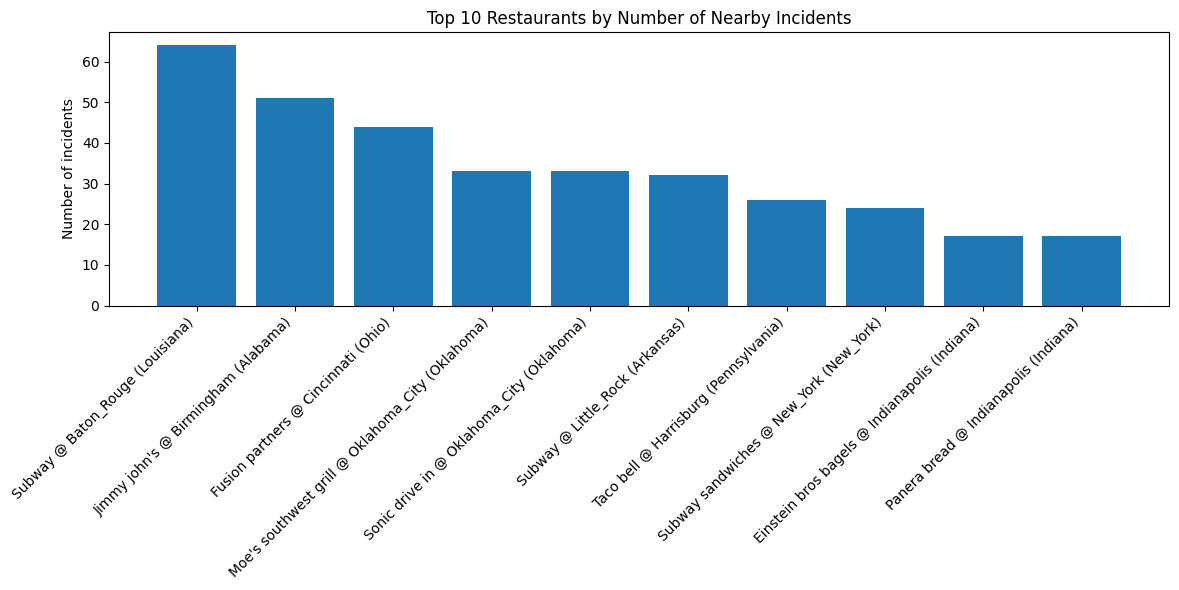

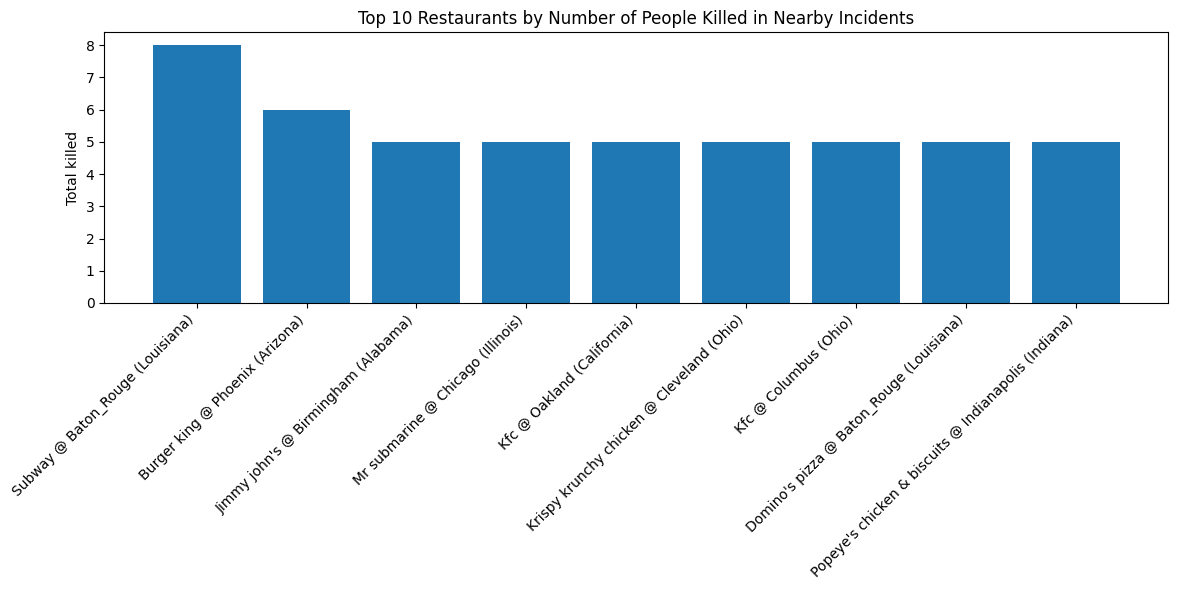

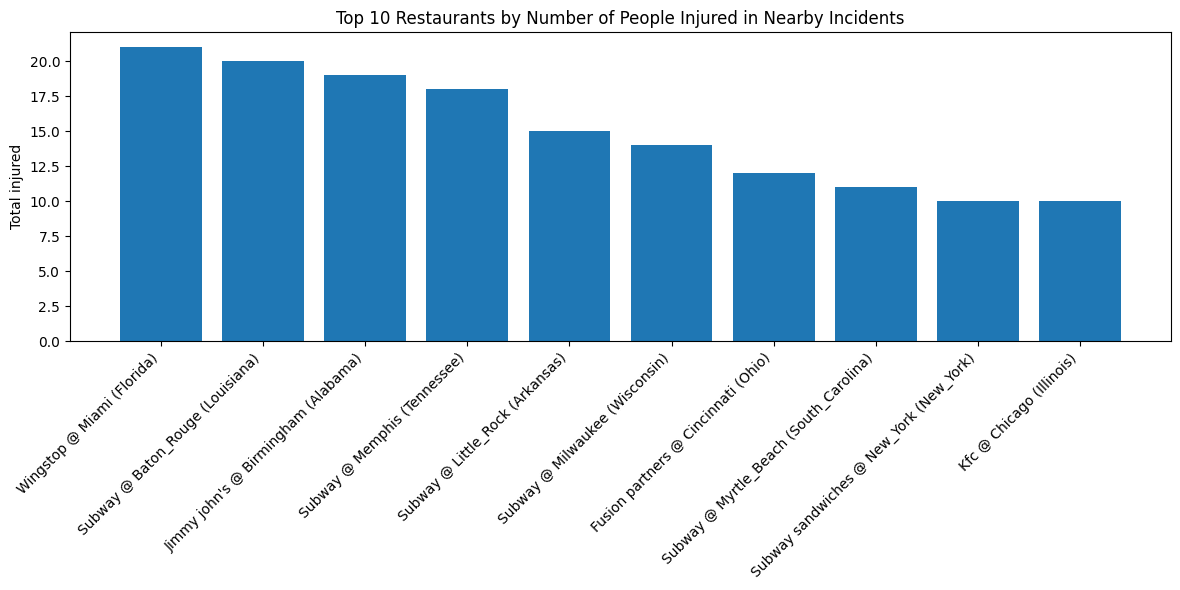

In [12]:
# Identify top 10 dangerous restaurants by number of incidents (and other criteria as tiebreakers)
top10_num_incidents = summary_df_with_incidents.sort_values(
    by=["num_incidents", "total_killed", "total_injured", "num_stolen_weapons"],
    ascending=[False, False, False, False]
).head(10)
import pprint
pp = pprint.PrettyPrinter(depth=3, sort_dicts=False)
# Print top 10 summary (name, address, incidents, killed, injured)
pp.pprint(top10_num_incidents[["name", "address", "num_incidents", "total_killed", "total_injured"]].to_dict(orient="records"))

# Bar plot: Top 10 by number of incidents
plt.figure(figsize=(12, 6))
plt.bar(top10_num_incidents["name"] + " @ " + top10_num_incidents["city"] + " (" + top10_num_incidents["state"] + ")", top10_num_incidents["num_incidents"])
plt.title("Top 10 Restaurants by Number of Nearby Incidents")
plt.ylabel("Number of incidents")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Top 10 by number of people killed
top10_killed = summary_df_with_incidents.sort_values(
    by=["total_killed", "total_injured", "num_stolen_weapons", "num_incidents"],
    ascending=[False, False, False, False]
).head(10)
plt.figure(figsize=(12, 6))
plt.bar(top10_killed["name"] + " @ " + top10_killed["city"] + " (" + top10_killed["state"] + ")", top10_killed["total_killed"])
plt.title("Top 10 Restaurants by Number of People Killed in Nearby Incidents")
plt.ylabel("Total killed")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Top 10 by number of people injured
top10_injured = summary_df_with_incidents.sort_values(
    by=["total_injured", "num_stolen_weapons", "num_incidents", "total_killed"],
    ascending=[False, False, False, False]
).head(10)
plt.figure(figsize=(12, 6))
plt.bar(top10_injured["name"] + " @ " + top10_injured["city"] + " (" + top10_injured["state"] + ")", top10_injured["total_injured"])
plt.title("Top 10 Restaurants by Number of People Injured in Nearby Incidents")
plt.ylabel("Total injured")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Gun Type and Status Distributions
Next, we analyze the distribution of firearm types and the status of guns (whether they were stolen or not) in the gun violence incidents. We parse the combined gun type entries and then visualize the breakdown.

✔ gun_classification.xlsx saved.


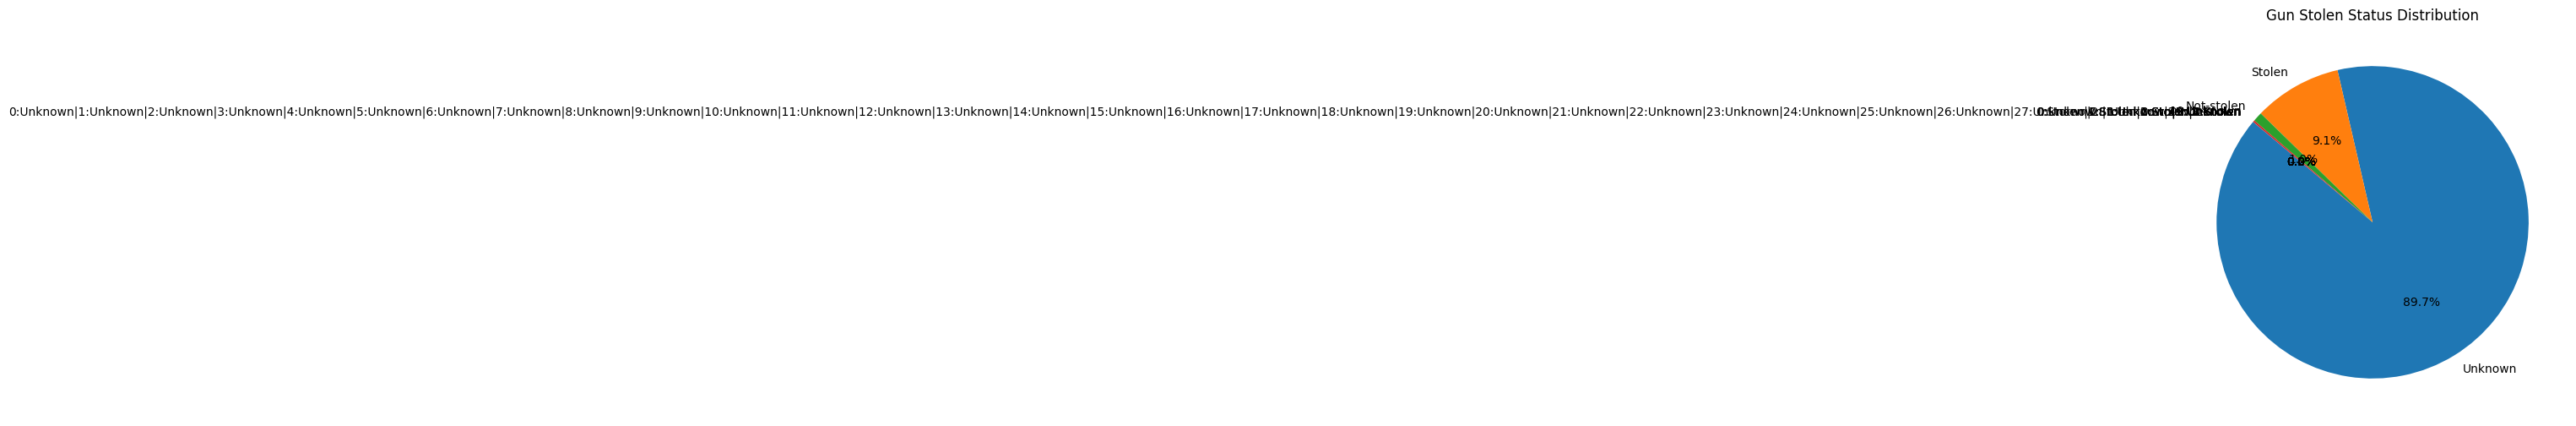

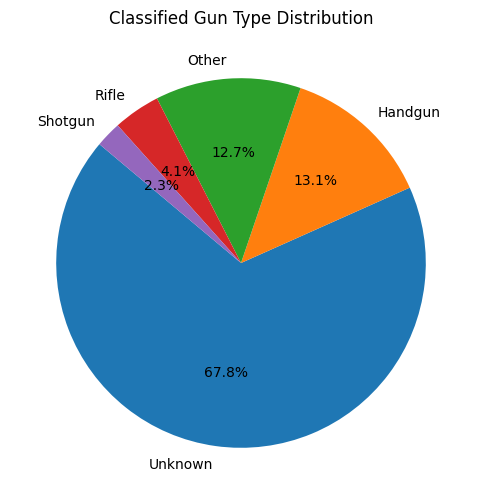

In [15]:
# Prepare data for gun type and stolen status analysis
df_gun_clean = df_gun.dropna(subset=["gun_type", "gun_stolen"])

# Helper functions to split combined entries
def extract_entries(entry):
    return [item.split("::")[1].strip() if "::" in item else item.strip() for item in str(entry).split("||")]

def classify_gun_type(gun):
    gun = gun.lower()
    if "handgun" in gun or "pistol" in gun or "revolver" in gun:
        return "Handgun"
    elif "rifle" in gun or "ak" in gun or "ar-" in gun or "7.62" in gun or "carbine" in gun:
        return "Rifle"
    elif "shotgun" in gun:
        return "Shotgun"
    elif "bb gun" in gun or "air" in gun:
        return "Airgun"
    elif "unknown" in gun:
        return "Unknown"
    else:
        return "Other"

# Split out each gun entry for all incidents
type_list, stolen_list, classified_list = [], [], []
for _, row in df_gun_clean.iterrows():
    types = extract_entries(row["gun_type"])
    stolen = extract_entries(row["gun_stolen"])
    for t, s in zip(types, stolen):
        type_list.append(t)
        stolen_list.append(s)
        classified_list.append(classify_gun_type(t))

# Create DataFrame of each gun involved
df_comb = pd.DataFrame({
    "gun_type": type_list,
    "gun_stolen": stolen_list,
    "gun_class": classified_list
})
# Save a crosstab of gun class vs stolen status to Excel for reference
classification_table = pd.crosstab(df_comb["gun_class"], df_comb["gun_stolen"])
classification_table.to_excel("gun_classification.xlsx")
print("✔ gun_classification.xlsx saved.")

# Pie chart of gun stolen status distribution
plt.figure(figsize=(6, 6))
df_comb["gun_stolen"].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
plt.title("Gun Stolen Status Distribution")
plt.ylabel("")
plt.show()

# Pie chart of classified gun type distribution
plt.figure(figsize=(6, 6))
df_comb["gun_class"].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
plt.title("Classified Gun Type Distribution")
plt.ylabel("")
plt.show()

### Geographic Visualization of Incidents
Finally, we visualize the location of fast food restaurants on a map of the United States. Restaurants with no incidents nearby are shown in blue, while those with incidents are shown in a color gradient from green (fewer incidents) to red (more incidents).

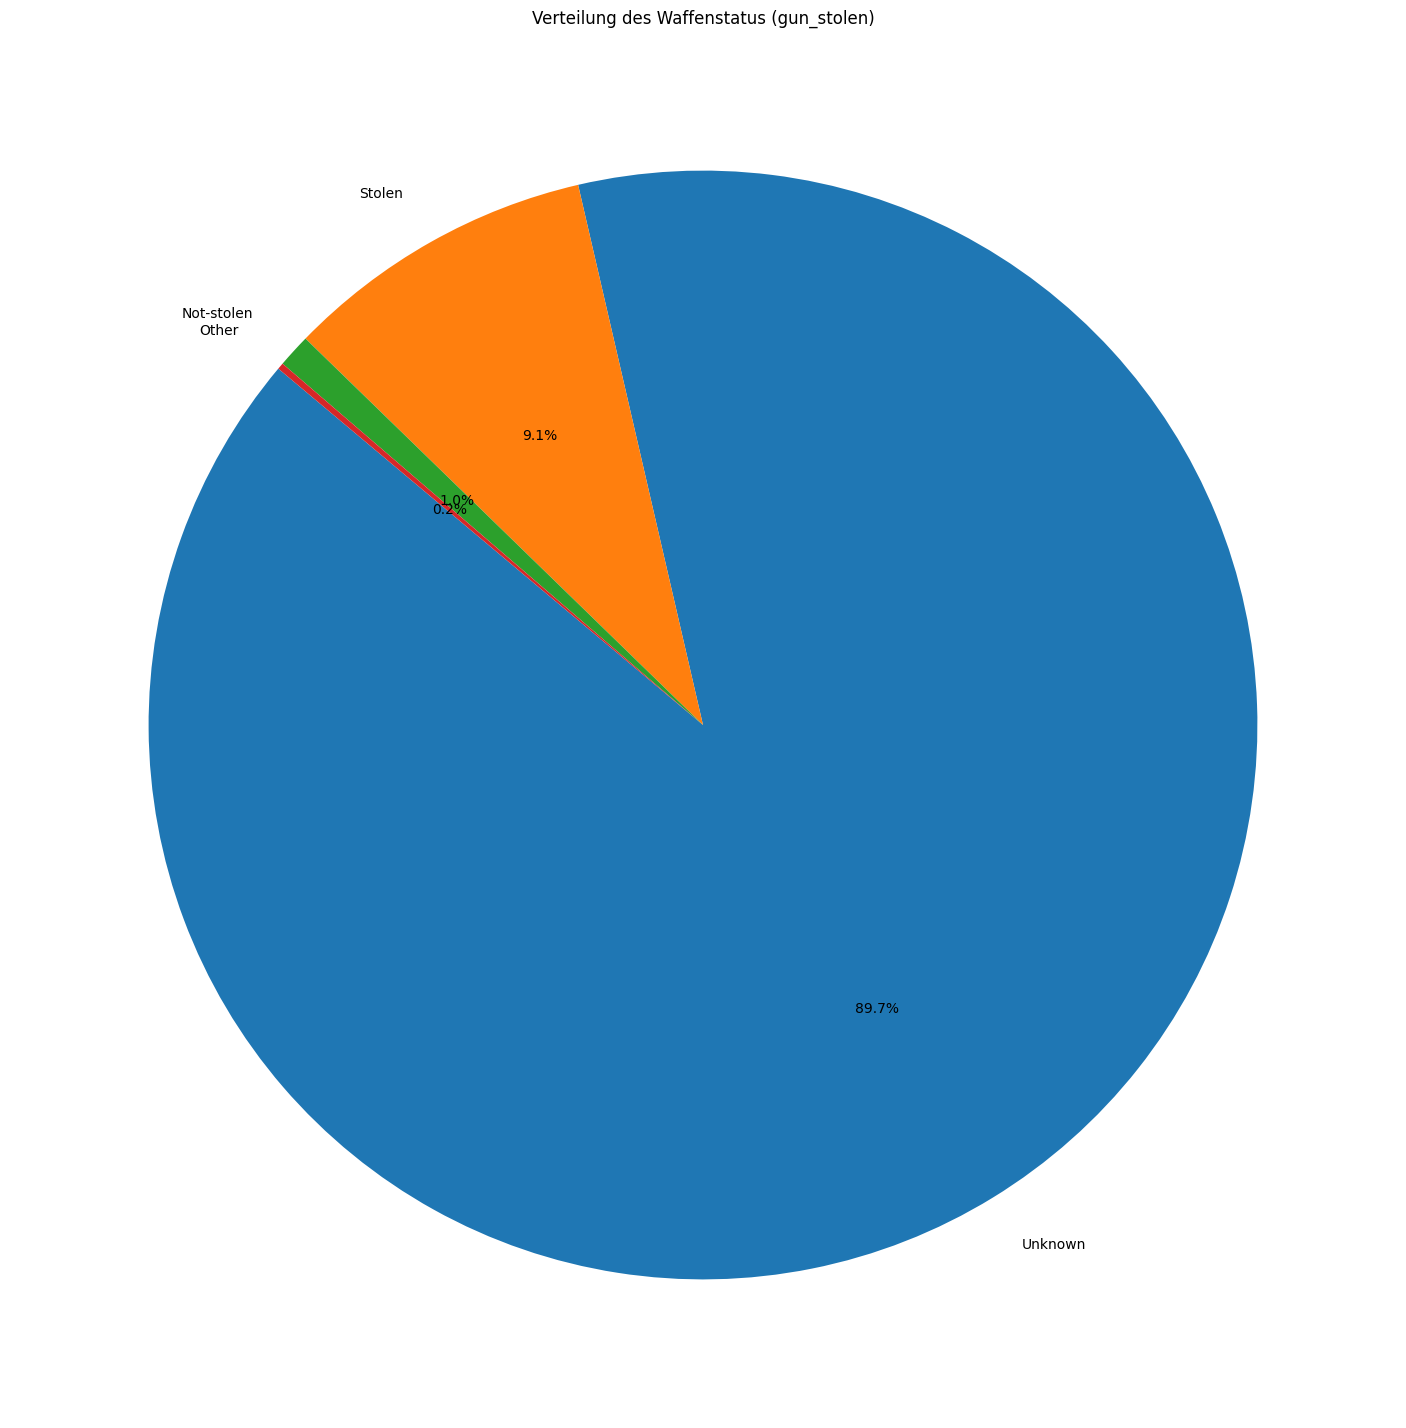

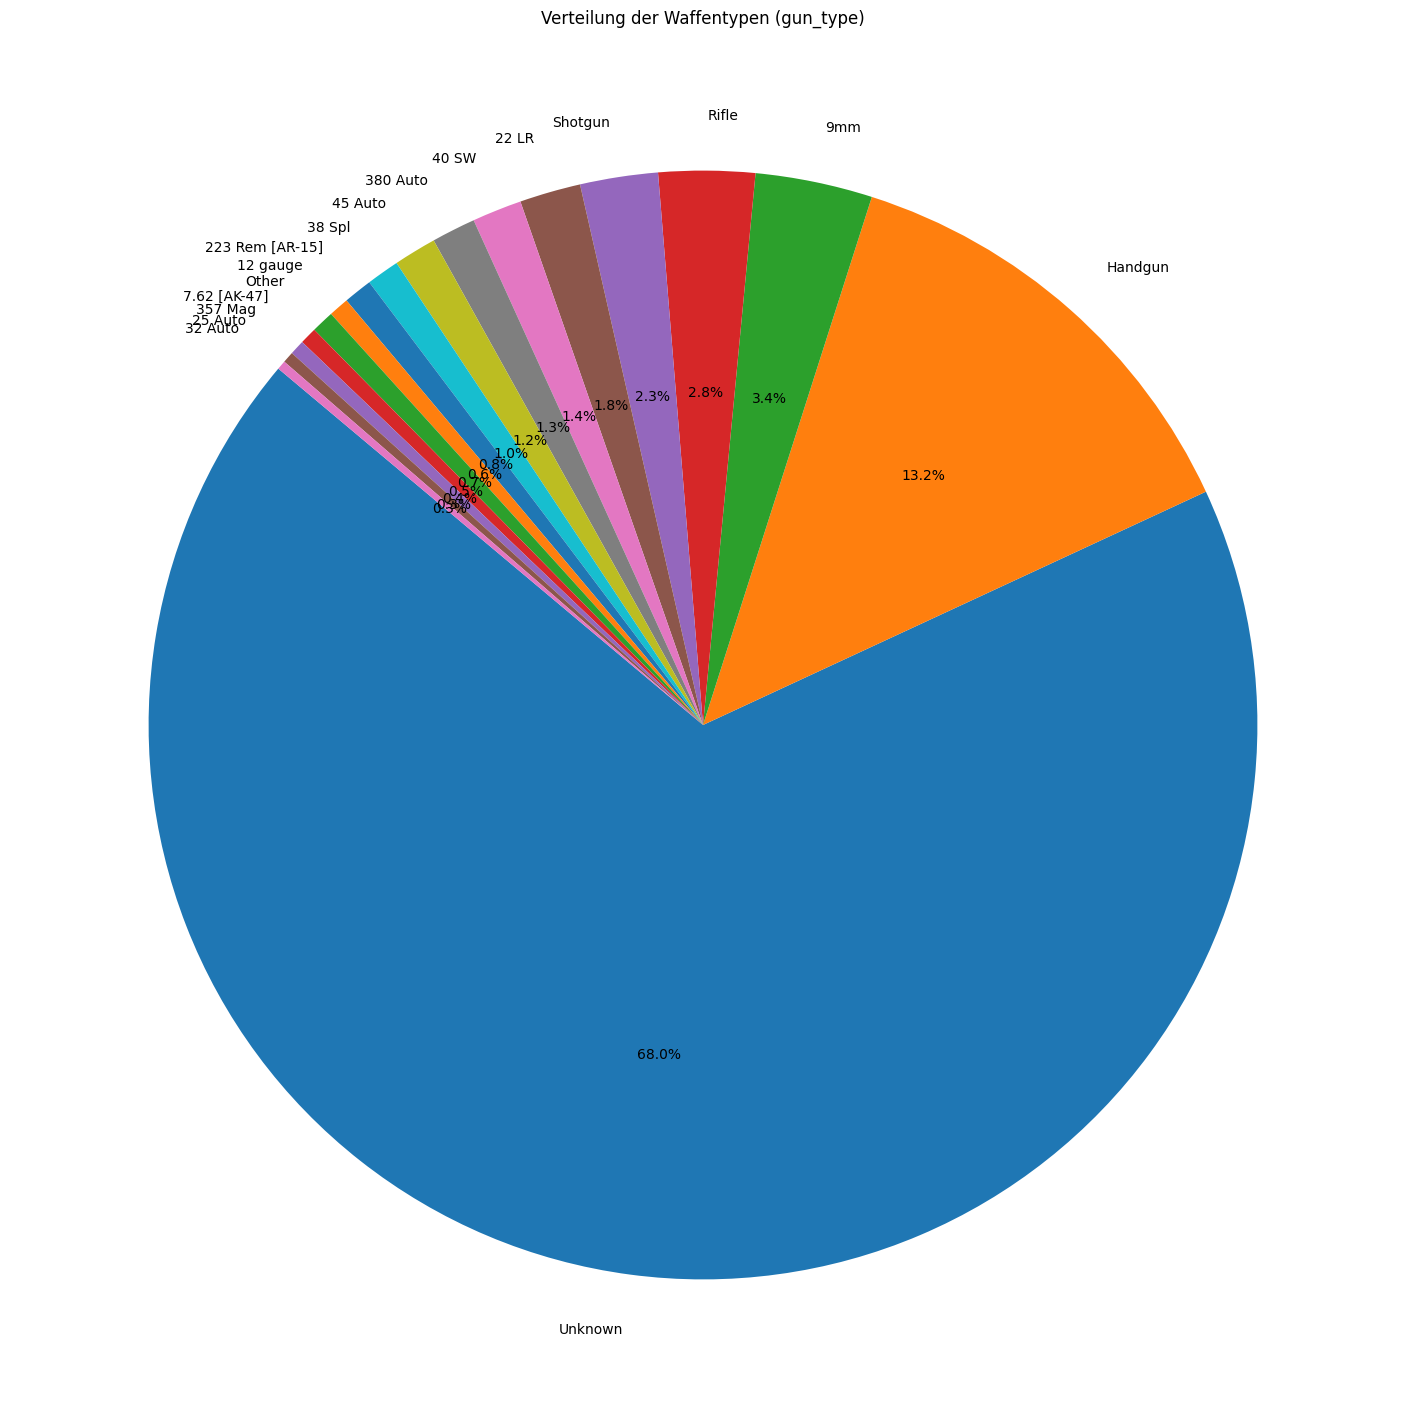

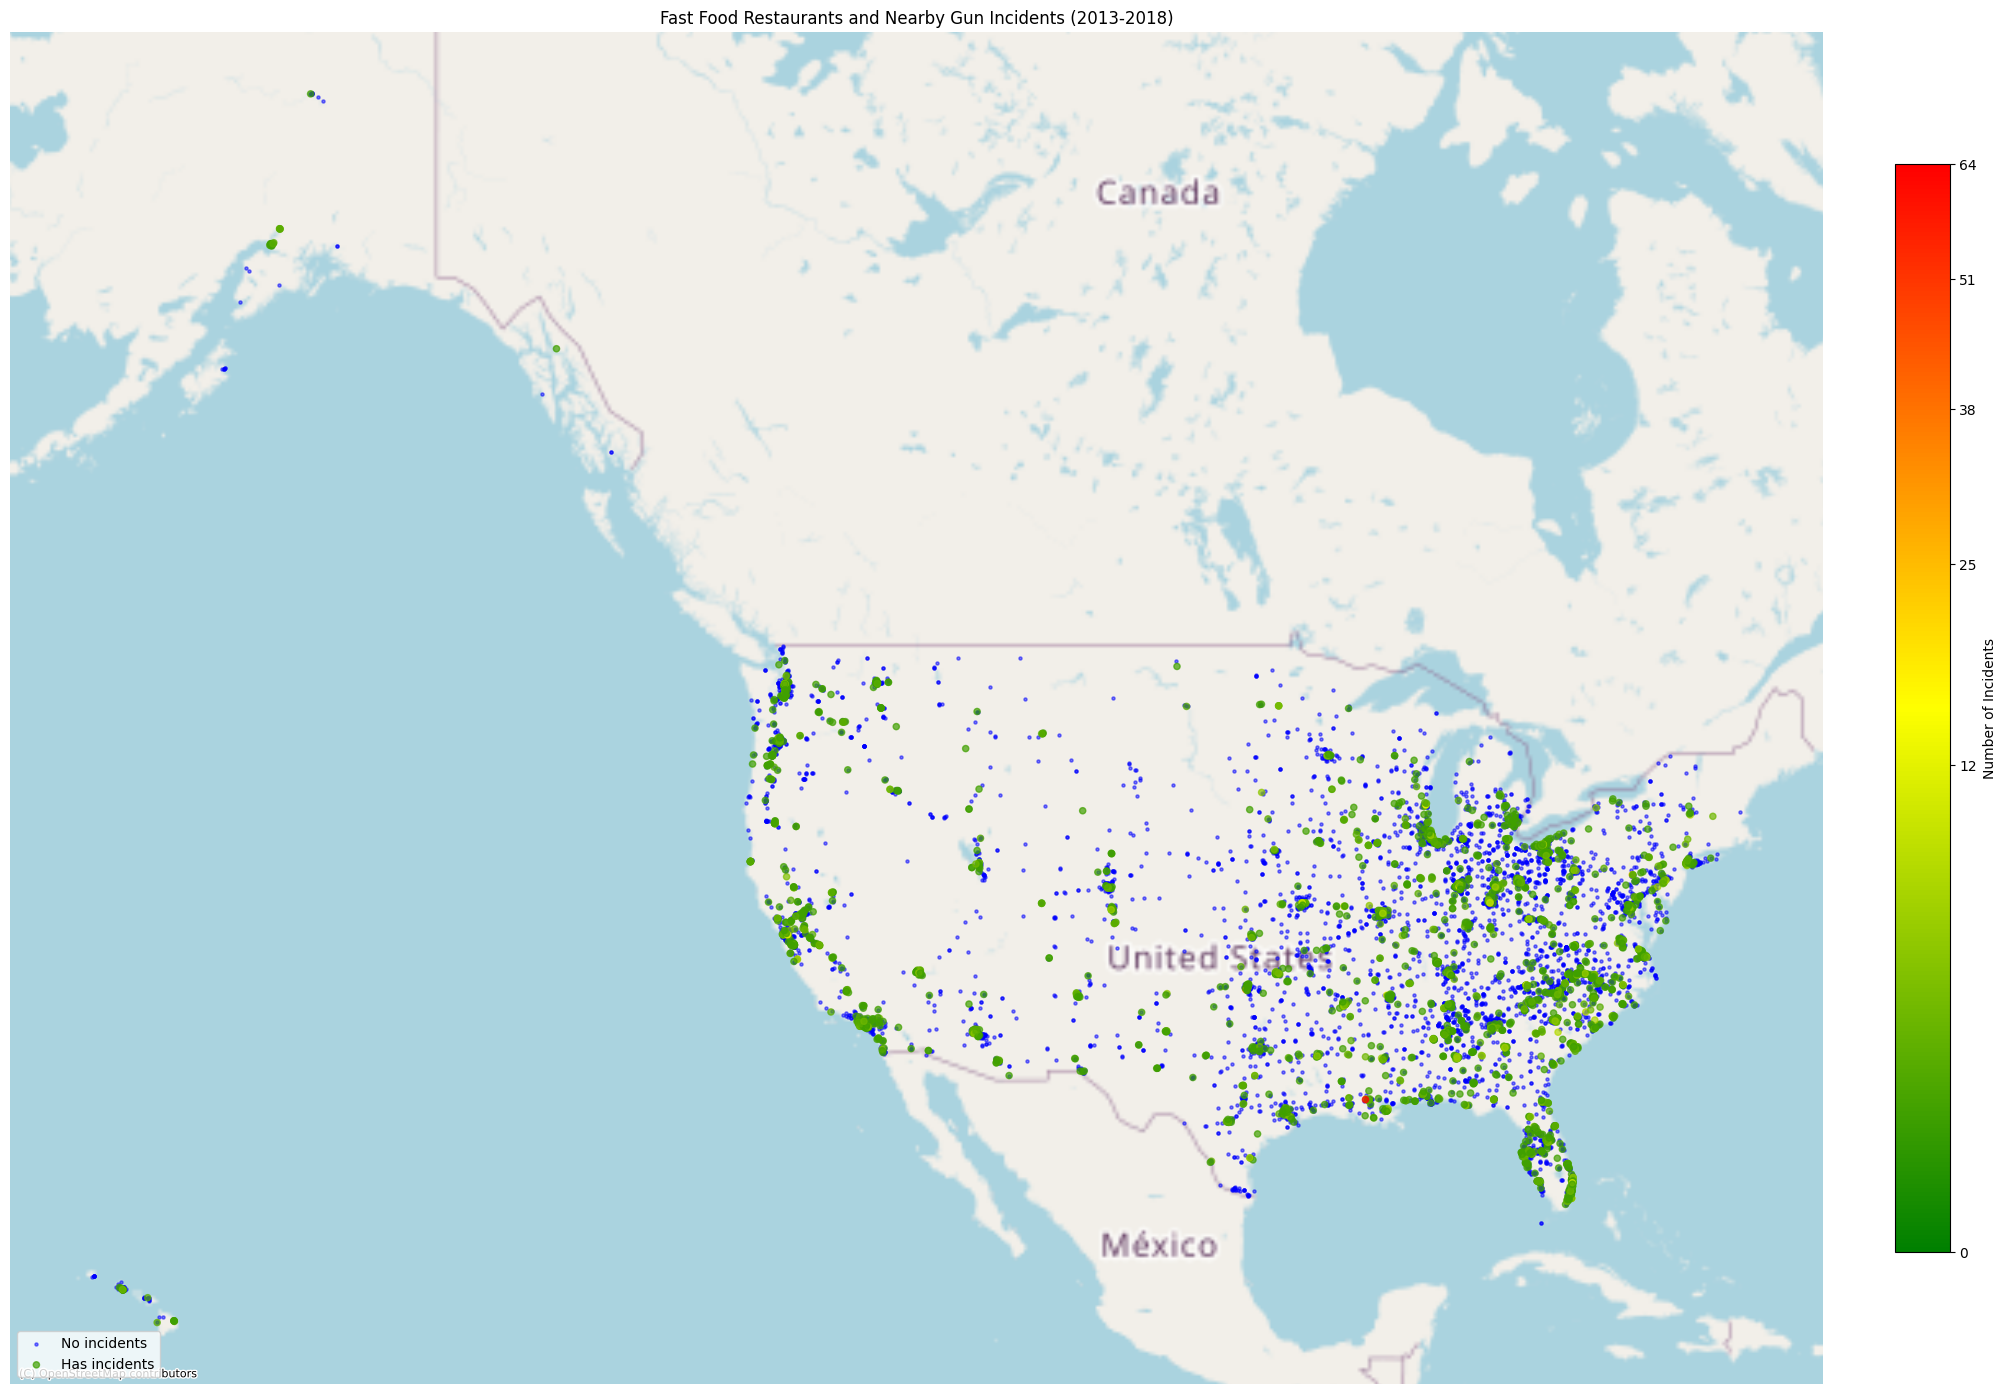

In [17]:
# Plot the US map with fast food locations and incident counts
# Create GeoDataFrames for restaurants with incidents and without incidents

def collapse_small_entries(series, threshold=0.002):
    total = series.sum()
    proportions = series / total
    large = series[proportions >= threshold]
    small = series[proportions < threshold]
    if not small.empty:
        large["Other"] = small.sum()
    return large

# Piechart for gun_stolen
stolen_all = []
for entry in df_gun_clean["gun_stolen"]:
    stolen_all.extend(extract_entries(entry))

df_stolen = pd.Series(stolen_all).value_counts()
df_stolen = collapse_small_entries(df_stolen)

plt.figure(figsize=(18, 18))
plt.pie(df_stolen, labels=df_stolen.index, autopct='%1.1f%%', startangle=140)
plt.title("Verteilung des Waffenstatus (gun_stolen)")
plt.show()

# Piechart for gun_type
type_all = []
for entry in df_gun_clean["gun_type"]:
    type_all.extend(extract_entries(entry))

df_types = pd.Series(type_all).value_counts()
df_types = collapse_small_entries(df_types)

plt.figure(figsize=(18, 18))
plt.pie(df_types, labels=df_types.index, autopct='%1.1f%%', startangle=140)
plt.title("Verteilung der Waffentypen (gun_type)")
plt.show()

# GeoDataFrame mit Projektion
# GeoDataFrame für Restaurants mit Vorfällen
geometry_with_incidents = [Point(xy) for xy in zip(summary_df_with_incidents["restaurant_longitude"], summary_df_with_incidents["restaurant_latitude"])]
# GeoDataFrame für Restaurants ohne Vorfälle
geometry_without_incidents = [Point(xy) for xy in zip(summary_df_without_incidents["restaurant_longitude"], summary_df_without_incidents["restaurant_latitude"])]

gdf_with_incidents = geopandas.GeoDataFrame(summary_df_with_incidents, geometry=geometry_with_incidents, crs="EPSG:4326").to_crs(epsg=3857)
gdf_without_incidents = geopandas.GeoDataFrame(summary_df_without_incidents, geometry=geometry_without_incidents, crs="EPSG:4326").to_crs(epsg=3857)

# Prepare color mapping based on incident counts (sqrt scale to spread values)
incident_counts = gdf_with_incidents["num_incidents"]
max_incidents = incident_counts.max()
transformed = np.sqrt(incident_counts)
max_trans = np.sqrt(max_incidents) if max_incidents > 0 else 0
cmap = mathcolors.LinearSegmentedColormap.from_list("incident_cmap", ["green", "yellow", "red"])
norm = mathcolors.Normalize(vmin=0, vmax=max_trans)
colors = [cmap(norm(x)) for x in transformed]

# Plot base
fig, ax = plt.subplots(figsize=(20, 20), constrained_layout=True)
gdf_without_incidents.plot(ax=ax, color="blue", markersize=5, alpha=0.5, label="No incidents")
gdf_with_incidents.plot(ax=ax, color=colors, markersize=20, alpha=0.7, label="Has incidents")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Fast Food Restaurants and Nearby Gun Incidents (2013-2018)")
ax.axis("off")
# Create colorbar for incident count scale
tick_values = np.linspace(0, max_incidents, num=6)
tick_positions = np.sqrt(tick_values)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04, ticks=tick_positions)
cbar.ax.set_yticklabels([f"{int(val)}" for val in tick_values])
cbar.set_label("Number of Incidents")
plt.legend(loc="lower left")
plt.show()